# U-Net for Spleen Segmentation (Task09_Spleen Dataset)

This notebook demonstrates a simplified U-Net model (no classes used) to segment the spleen in 2D MRI slices from the Medical Segmentation Decathlon Task09_Spleen dataset.

In [11]:
# !pip install numpy torch torchvision matplotlib nibabel opencv-python tqdm

In [12]:

import os
import nibabel as nib
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Parameters
image_size = 128
data_dir = "./Task09_Spleen"
epochs = 5
batch_size = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [13]:

def load_slices():
    image_slices = []
    mask_slices = []

    image_files = sorted(os.listdir(os.path.join(data_dir, "imagesTr")))
    for file in tqdm(image_files, desc="Loading data"):
        if not file.endswith(".nii.gz") or file.startswith("._"):
            continue  # skip hidden/system files

        img_path = os.path.join(data_dir, "imagesTr", file)
        lbl_path = os.path.join(data_dir, "labelsTr", file.replace("img", "label"))

        img_nii = nib.load(img_path).get_fdata()
        lbl_nii = nib.load(lbl_path).get_fdata()

        for i in range(img_nii.shape[-1]):
            img_slice = img_nii[:, :, i]
            lbl_slice = lbl_nii[:, :, i]

            if np.max(lbl_slice) == 0:
                continue

            img_slice = cv2.resize(img_slice, (image_size, image_size))
            lbl_slice = cv2.resize(lbl_slice, (image_size, image_size))

            img_slice = (img_slice - np.min(img_slice)) / (np.max(img_slice) - np.min(img_slice))

            image_slices.append(img_slice.astype(np.float32))
            mask_slices.append((lbl_slice > 0).astype(np.float32))

    return np.array(image_slices), np.array(mask_slices)


images, masks = load_slices()
images = images[:, np.newaxis, :, :]
masks = masks[:, np.newaxis, :, :]
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)
train_data = list(zip(X_train, y_train))
val_data = list(zip(X_val, y_val))


Loading data: 100%|██████████| 82/82 [00:21<00:00,  3.82it/s] 



In [14]:

conv1_1 = nn.Conv2d(1, 32, kernel_size=3, padding=1).to(device)
conv1_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1).to(device)
conv2_1 = nn.Conv2d(32, 64, kernel_size=3, padding=1).to(device)
conv2_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1).to(device)
pool = nn.MaxPool2d(2)

conv3_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1).to(device)
conv3_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1).to(device)

upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2).to(device)
dec2_1 = nn.Conv2d(128, 64, kernel_size=3, padding=1).to(device)
dec2_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1).to(device)
upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2).to(device)
dec1_1 = nn.Conv2d(64, 32, kernel_size=3, padding=1).to(device)
dec1_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1).to(device)
final_conv = nn.Conv2d(32, 1, kernel_size=1).to(device)


In [15]:

def forward_unet(x):
    e1 = F.relu(conv1_1(x))
    e1 = F.relu(conv1_2(e1))
    p1 = pool(e1)

    e2 = F.relu(conv2_1(p1))
    e2 = F.relu(conv2_2(e2))
    p2 = pool(e2)

    b = F.relu(conv3_1(p2))
    b = F.relu(conv3_2(b))

    up2 = upconv2(b)
    d2 = torch.cat([up2, e2], dim=1)
    d2 = F.relu(dec2_1(d2))
    d2 = F.relu(dec2_2(d2))

    up1 = upconv1(d2)
    d1 = torch.cat([up1, e1], dim=1)
    d1 = F.relu(dec1_1(d1))
    d1 = F.relu(dec1_2(d1))

    out = torch.sigmoid(final_conv(d1))
    return out


In [16]:
def combined_loss(pred, target):
    bce = F.binary_cross_entropy(pred, target)
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    dice = 1 - ((2. * intersection + 1) / (pred.sum() + target.sum() + 1))
    return bce + dice


In [ ]:

params = list(conv1_1.parameters()) + list(conv1_2.parameters()) + list(conv2_1.parameters()) + list(conv2_2.parameters()) + list(conv3_1.parameters()) + list(conv3_2.parameters()) +          list(upconv2.parameters()) + list(dec2_1.parameters()) + list(dec2_2.parameters()) +          list(upconv1.parameters()) + list(dec1_1.parameters()) + list(dec1_2.parameters()) +          list(final_conv.parameters())

optimizer = torch.optim.Adam(params, lr=1e-3)


Epoch 1/5 - Train Loss: 0.8529 - Val Loss: 0.6191
Epoch 2/5 - Train Loss: 0.5318 - Val Loss: 0.4402
Epoch 2/5 - Train Loss: 0.5318 - Val Loss: 0.4402
Epoch 3/5 - Train Loss: 0.3937 - Val Loss: 0.3169
Epoch 3/5 - Train Loss: 0.3937 - Val Loss: 0.3169
Epoch 4/5 - Train Loss: 0.2869 - Val Loss: 0.2599
Epoch 4/5 - Train Loss: 0.2869 - Val Loss: 0.2599
Epoch 5/5 - Train Loss: 0.2248 - Val Loss: 0.3081
Epoch 5/5 - Train Loss: 0.2248 - Val Loss: 0.3081


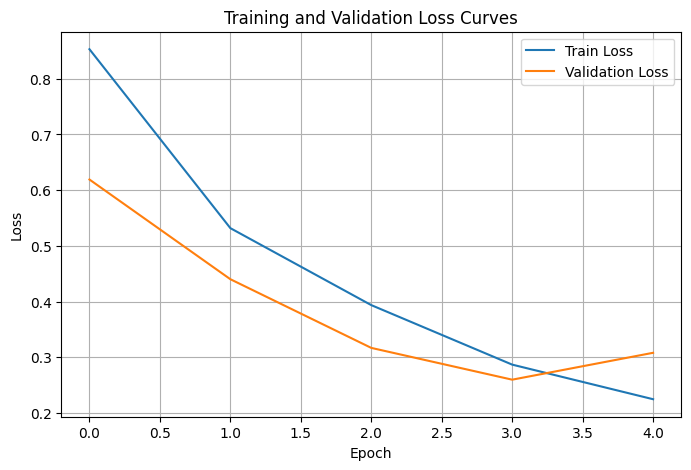

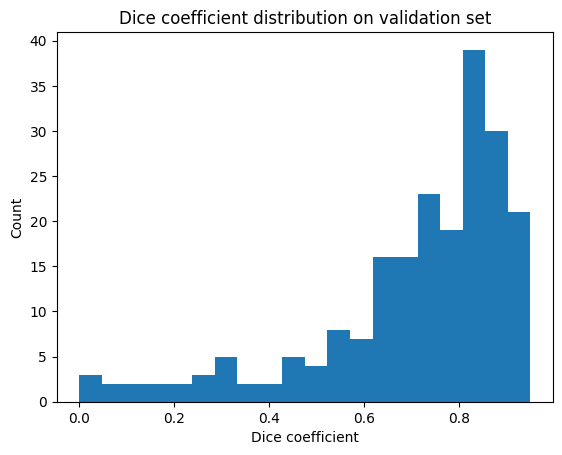

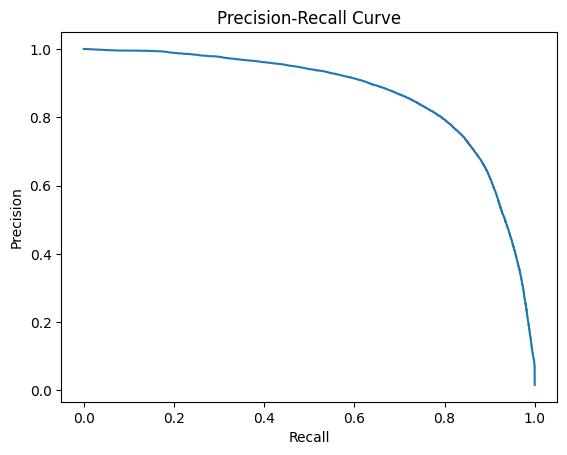

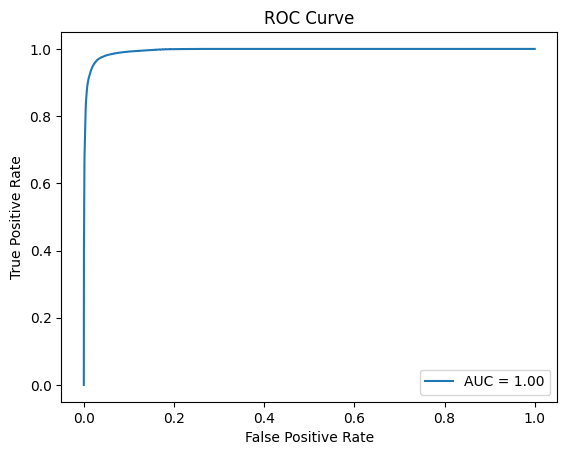

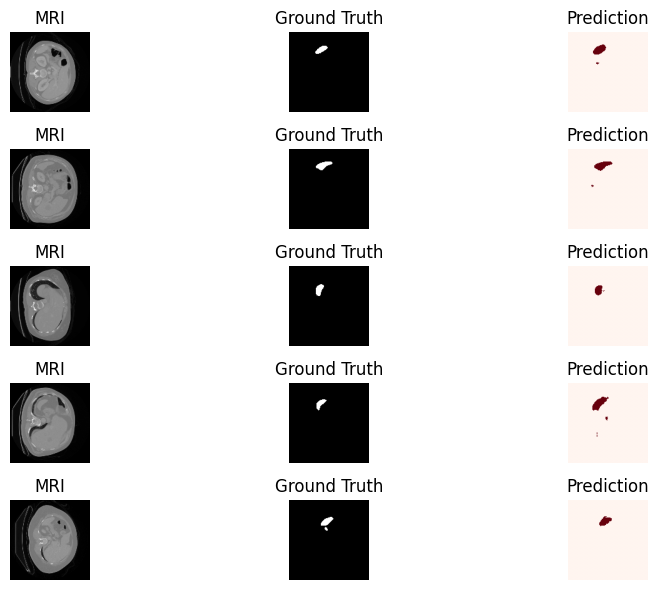

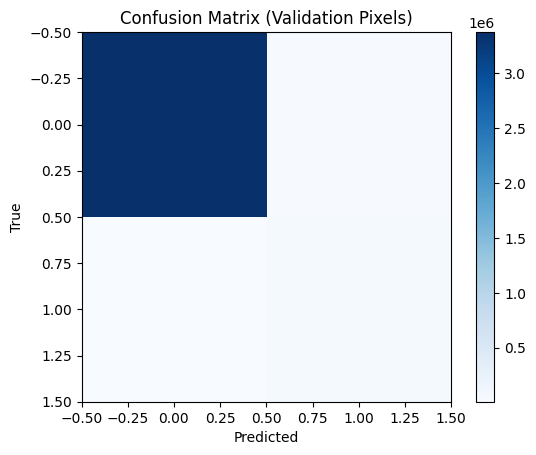

In [18]:
train_losses = []
val_losses = []

for epoch in range(epochs):
    np.random.shuffle(train_data)
    train_loss = 0.0
    num_batches = 0

    # Training loop
    for i in range(0, len(train_data), batch_size):
        batch = train_data[i:i+batch_size]
        imgs = torch.tensor([b[0] for b in batch], dtype=torch.float32).to(device)
        lbls = torch.tensor([b[1] for b in batch], dtype=torch.float32).to(device)

        preds = forward_unet(imgs)
        loss = combined_loss(preds, lbls)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        num_batches += 1

    avg_train_loss = train_loss / num_batches
    train_losses.append(avg_train_loss)

    # Validation loop
    val_loss = 0.0
    val_batches = 0
    with torch.no_grad():
        for i in range(0, len(val_data), batch_size):
            batch = val_data[i:i+batch_size]
            imgs = torch.tensor([b[0] for b in batch], dtype=torch.float32).to(device)
            lbls = torch.tensor([b[1] for b in batch], dtype=torch.float32).to(device)

            preds = forward_unet(imgs)
            loss = combined_loss(preds, lbls)

            val_loss += loss.item()
            val_batches += 1

    avg_val_loss = val_loss / val_batches
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

# After training, plot the loss curves
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

# Plot Dice coefficient distribution on validation set

dice_scores = []
with torch.no_grad():
    for img, mask in zip(X_val, y_val):
        img_t = torch.tensor(img[None], dtype=torch.float32).to(device)
        pred = forward_unet(img_t).cpu().numpy()[0, 0]
        pred_bin = (pred > 0.7).astype(np.uint8)
        gt_bin = mask[0].astype(np.uint8)
        intersection = (pred_bin * gt_bin).sum()
        dice = (2. * intersection) / (pred_bin.sum() + gt_bin.sum() + 1e-8)
        dice_scores.append(dice)
plt.figure()
plt.hist(dice_scores, bins=20)
plt.xlabel("Dice coefficient")
plt.ylabel("Count")
plt.title("Dice coefficient distribution on validation set")
plt.show()

# Precision-Recall curve
from sklearn.metrics import precision_recall_curve, auc
all_preds = []
all_gts = []
with torch.no_grad():
    for img, mask in zip(X_val, y_val):
        img_t = torch.tensor(img[None], dtype=torch.float32).to(device)
        pred = forward_unet(img_t).cpu().numpy()[0, 0].flatten()
        gt = mask[0].flatten()
        all_preds.extend(pred)
        all_gts.extend(gt)
precision, recall, _ = precision_recall_curve(all_gts, all_preds)
plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

# ROC curve and AUC
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(all_gts, all_preds)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Qualitative results grid: show 5 random validation images with GT and prediction
import random
num_show = 5
indices = random.sample(range(len(X_val)), num_show)
plt.figure(figsize=(10, 6))
for i, idx in enumerate(indices):
    img = X_val[idx, 0]
    mask = y_val[idx, 0]
    with torch.no_grad():
        pred = forward_unet(torch.tensor(X_val[idx:idx+1], dtype=torch.float32).to(device)).cpu().numpy()[0, 0]
        pred_bin = (pred > 0.7).astype(np.uint8)
    plt.subplot(num_show, 3, i*3+1)
    plt.imshow(img, cmap='gray')
    plt.title('MRI')
    plt.axis('off')
    plt.subplot(num_show, 3, i*3+2)
    plt.imshow(mask, cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(num_show, 3, i*3+3)
    plt.imshow(pred_bin, cmap='Reds')
    plt.title('Prediction')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Confusion matrix for all validation pixels
from sklearn.metrics import confusion_matrix
all_preds_bin = (np.array(all_preds) > 0.7).astype(np.uint8)
all_gts_bin = np.array(all_gts).astype(np.uint8)
cm = confusion_matrix(all_gts_bin, all_preds_bin)
plt.figure()
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix (Validation Pixels)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.show()

In [19]:
# model_state = {
#     'conv1_1': conv1_1.state_dict(),
#     'conv1_2': conv1_2.state_dict(),
#     'conv2_1': conv2_1.state_dict(),
#     'conv2_2': conv2_2.state_dict(),
#     'conv3_1': conv3_1.state_dict(),
#     'conv3_2': conv3_2.state_dict(),
#     'upconv2': upconv2.state_dict(),
#     'dec2_1': dec2_1.state_dict(),
#     'dec2_2': dec2_2.state_dict(),
#     'upconv1': upconv1.state_dict(),
#     'dec1_1': dec1_1.state_dict(),
#     'dec1_2': dec1_2.state_dict(),
#     'final_conv': final_conv.state_dict()
# }

# torch.save(model_state, "model.pth")
# print("Model weights saved to unet_spleen_weights.pth")